In [1]:
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from process_data import process_data, process_data_clinical_dose
from policy import LinUCB, FixedDose, ClinicalDose, LassoUCB, RobustLinExp3, LinTS
from bandit import ContextualBandit
from plot import plot_ci

def run (bandit, policy, T=1000, num_trials=3, seed=2023):
    
    cum_regrets = []
    correctness = []
    np.random.seed(seed)
    
    for i, trial_seed in enumerate(np.random.randint(1, 100, num_trials)):
        
        bandit.reset(seed=trial_seed)
        policy.reset()
        
        for t in tqdm(range(T)):
            
            fea, lab = bandit.present()
            arm = policy.predict(fea, lab, t)
            reward = bandit.pull(arm)
            if policy.__class__.__name__ == 'RobustLinExp3':
                policy.update(fea, lab, reward) 
            else:                           
                policy.update(fea, arm, reward)
            
        # print(f'Trial #{i+1} for ({policy.__class__.__name__}) with Random Seed: {trial_seed}')
        # print(f'Total Rewards ({policy.__class__.__name__}): {sum(bandit.rewards)}; Correctness: {bandit.correctness[-1]}')
        correctness.append(bandit.correctness[-1])
    
    return correctness

def main(features, labels, clinical_dose_df, clinical_dose_cols, clinical_dose_labels, 
         reward_unit=10, T=1000, num_trials=3, seed=2023):
    
    np.random.seed(seed)
    plot_df = pd.DataFrame(columns=['Linear', 'Unit', 'Cor'])
    for linear in [True, False]:
        for reward_unit in [1, 3, 10, 30, 100]:
            linucb_cb = ContextualBandit(features=features, labels=labels, linear_reward=linear, reward_unit=reward_unit)
            linucb = LinUCB(num_features=linucb_cb.num_features, num_labels=linucb_cb.k)
            cors = run(linucb_cb, linucb, T=T, num_trials=num_trials, seed=seed)
            for cor in cors:
                plot_df.loc[len(plot_df)] = [linear, str(reward_unit), cor]
    return plot_df

In [2]:
path = 'data/warfarin.csv'
features, labels = process_data(path)
clinical_dose_features, clinical_dose_cols, clinical_dose_labels = process_data_clinical_dose(path)
plot_df = main(features, labels, clinical_dose_features, clinical_dose_cols, clinical_dose_labels, T=features.shape[0], num_trials=3, seed=2023)

100%|██████████| 5528/5528 [00:20<00:00, 267.01it/s]


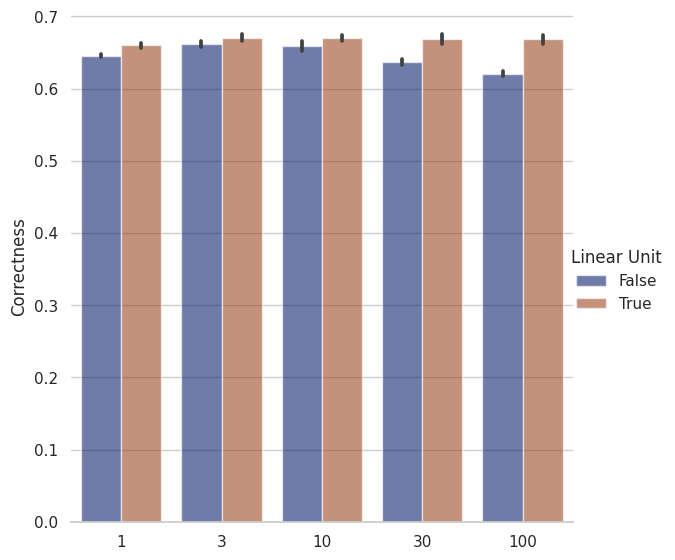

In [7]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=plot_df, kind="bar",
    x="Unit", y="Cor", hue="Linear",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Correctness")
g.legend.set_title("Linear Unit")

In [4]:
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from process_data import process_data, process_data_clinical_dose
from policy import LinUCB, FixedDose, ClinicalDose, LassoUCB, RobustLinExp3, LinTS
from bandit import ContextualBandit
from plot import plot_ci

def run (bandit, policy, T=1000, num_trials=3, seed=2023):
    
    cum_regrets = []
    correctness = []
    np.random.seed(seed)
    
    for i, trial_seed in enumerate(np.random.randint(1, 100, num_trials)):
        
        bandit.reset(seed=trial_seed)
        policy.reset()
        
        for t in tqdm(range(T)):
            
            fea, lab = bandit.present()
            arm = policy.predict(fea, lab, t)
            reward = bandit.pull(arm)
            if policy.__class__.__name__ == 'RobustLinExp3':
                policy.update(fea, lab, reward) 
            else:                           
                policy.update(fea, arm, reward)
        correctness.append(bandit.correctness)
    
    return correctness

def main(features, labels, clinical_dose_df, clinical_dose_cols, clinical_dose_labels, 
         reward_unit=10, T=1000, num_trials=3, seed=2023):
    
    np.random.seed(seed)
    plot_dt = {}
    for linear in [True, False]:
        lin = 'Linear' if linear else 'Exponential'
        for reward_unit in [1, 3, 10, 30, 100]:
            dt = []
            linucb_cb = ContextualBandit(features=features, labels=labels, linear_reward=linear, reward_unit=reward_unit)
            linucb = LinUCB(num_features=linucb_cb.num_features, num_labels=linucb_cb.k)
            cors = run(linucb_cb, linucb, T=T, num_trials=num_trials, seed=seed)
            plot_dt[lin+f' Reward Unit {reward_unit}'] = np.array(cors)
    return plot_dt

In [5]:
path = 'data/warfarin.csv'
features, labels = process_data(path)
clinical_dose_features, clinical_dose_cols, clinical_dose_labels = process_data_clinical_dose(path)
plot_dt = main(features, labels, clinical_dose_features, clinical_dose_cols, clinical_dose_labels, T=features.shape[0], num_trials=3, seed=2023)

100%|██████████| 5528/5528 [00:20<00:00, 272.53it/s]


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from util import get_ci

def plot_ci(plot_data, confidence=0.95, save_path='figures/myplot.png'):
    
    for model, dt in plot_data.items():
        T = dt.shape[1]
        means = np.apply_along_axis(np.mean, 0, dt)
        low_ci = np.apply_along_axis(get_ci, 0, dt, kind='low', confidence=confidence)
        high_ci = np.apply_along_axis(get_ci, 0, dt, kind='high', confidence=confidence)
        
        if model.startswith('Exp'):
            linestyle = (0, (5, 5))
            linewidth = 1
        else:
            linestyle = None
            linewidth = 1
        
        plt.plot(range(T), means, label=model, linestyle=linestyle, linewidth=linewidth)
        # plt.fill_between(range(T), low_ci, high_ci, alpha=.2)
        
    plt.legend(bbox_to_anchor=(1.04,1))    
    plt.ylim([0.5, 0.7])
    plt.xlabel('timestep')
    plt.ylabel('Correctness')
    plt.show()

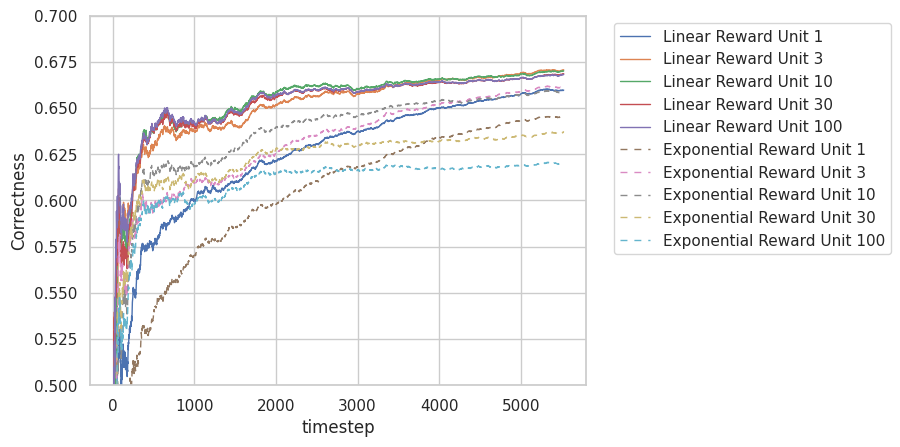

In [39]:
plot_ci(plot_data=plot_dt)